# Hungary Load Forecasting — CNN1D (15-minute) — Proper Sequence Training

✅ Input shape is **(samples, timesteps, features)** using a sliding window on the time axis.  
✅ Target is the **next 15-minute load**.  
✅ Split is fixed to avoid early rolling-window NaNs:

- **Train:** 2016-01-01 to 2017-12-31  
- **Validation:** 2018-01-01 to 2018-12-31  
- **Test:** 2019-01-01 to 2019-12-31  

We also drop rows with missing engineered features before windowing, so training is stable.

In [19]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

sns.set_style("whitegrid")
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)

TensorFlow: 2.20.0


In [20]:
MODEL_NAME = "cnn1d"
print("Model:", MODEL_NAME)

Model: cnn1d


## 1) Load Dataset

In [21]:
DATA_PATH = "../data/processed/hungary_merged_dataset_2015_2024.csv"

if not os.path.exists(DATA_PATH):
    print("⚠️ Dataset not found:", DATA_PATH)
    print("Creating a small synthetic 15-min dataset (2016-2019) so the notebook can run end-to-end.")
    dt = pd.date_range("2016-01-01", "2019-12-31 23:45:00", freq="15min", tz="UTC")
    df = pd.DataFrame({
        "datetime": dt,
        "load_MW": 5000 + 800*np.sin(2*np.pi*(dt.hour*60+dt.minute)/(24*60)) + 200*np.sin(2*np.pi*dt.dayofweek/7)
                   + 100*np.sin(2*np.pi*dt.dayofyear/365) + np.random.normal(0, 120, len(dt)),
        "temperature_2m": 10 + 8*np.sin(2*np.pi*dt.dayofyear/365) + np.random.normal(0, 1.5, len(dt)),
        "is_weekend": (dt.dayofweek >= 5).astype(int),
    })
else:
    df = pd.read_csv(DATA_PATH)
    df["datetime"] = pd.to_datetime(df["datetime"], utc=True)

df = df.sort_values("datetime").drop_duplicates(subset=["datetime"]).reset_index(drop=True)

print("Rows:", f"{len(df):,}")
print("Date range:", df["datetime"].min(), "to", df["datetime"].max())

# Check frequency
deltas = df["datetime"].diff().dropna()
step = deltas.value_counts().idxmax()
freq_min = int(step / pd.Timedelta(minutes=1))
print("Detected frequency (minutes):", freq_min)
assert freq_min == 15, "This notebook expects 15-minute data."

Rows: 350,688
Date range: 2015-01-01 00:00:00+00:00 to 2024-12-31 23:45:00+00:00
Detected frequency (minutes): 15


## 2) Feature Selection + Drop Missing

In [22]:
target_col = "load_MW"

# Use numeric columns only (safe for keras)
numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
assert target_col in numeric_cols, f"{target_col} not found!"

feature_cols = [c for c in numeric_cols if c != target_col]

print("Num features:", len(feature_cols))
print("Example features:", feature_cols[:15])

# IMPORTANT: Drop rows with missing engineered features (rolling/lag create NaNs)
before = len(df)
df = df.dropna(subset=[target_col] + feature_cols).reset_index(drop=True)
after = len(df)
print(f"Dropped NaN rows: {before-after:,} (now {after:,} rows)")

Num features: 74
Example features: ['load_MW_lag_48h', 'load_MW_lag_72h', 'load_MW_lag_96h', 'load_MW_lag_120h', 'load_MW_lag_144h', 'load_MW_lag_168h', 'load_MW_rolling_mean_48h', 'load_MW_rolling_std_48h', 'load_MW_rolling_min_48h', 'load_MW_rolling_max_48h', 'load_MW_rolling_mean_72h', 'load_MW_rolling_std_72h', 'load_MW_rolling_min_72h', 'load_MW_rolling_max_72h', 'load_MW_rolling_mean_96h']
Dropped NaN rows: 672 (now 350,016 rows)


## 3) Train/Val/Test Split (Fixed: 2016-2019)

In [23]:
# Fixed split (to avoid early missing values from rolling features)
train_start, train_end = "2016-01-01", "2018-01-01"
val_start, val_end     = "2018-01-01", "2019-01-01"
test_start, test_end   = "2019-01-01", "2020-01-01"

dates = df["datetime"]

train_df = df[(dates >= train_start) & (dates < train_end)].copy()
val_df   = df[(dates >= val_start) & (dates < val_end)].copy()
test_df  = df[(dates >= test_start) & (dates < test_end)].copy()

print("Train:", f"{len(train_df):,}")
print("Val  :", f"{len(val_df):,}")
print("Test :", f"{len(test_df):,}")

assert len(train_df) > 0 and len(val_df) > 0 and len(test_df) > 0, "One of the splits is empty. Check your dataset date range."

Train: 70,176
Val  : 35,040
Test : 35,040


## 4) Scaling + Sliding Window (True Time-Series Input)

In [24]:
# Scale using ONLY train data
scaler = RobustScaler()

X_train_raw = train_df[feature_cols].values
X_val_raw   = val_df[feature_cols].values
X_test_raw  = test_df[feature_cols].values

scaler.fit(X_train_raw)

X_train_scaled = scaler.transform(X_train_raw).astype("float32")
X_val_scaled   = scaler.transform(X_val_raw).astype("float32")
X_test_scaled  = scaler.transform(X_test_raw).astype("float32")

y_train = train_df[target_col].values.astype("float32")
y_val   = val_df[target_col].values.astype("float32")
y_test  = test_df[target_col].values.astype("float32")

# Sliding window settings (15-min -> 4 steps per hour)
K_HOURS = 24
STEPS_PER_HOUR = 4
K_STEPS = K_HOURS * STEPS_PER_HOUR

print("K_HOURS:", K_HOURS, "=> K_STEPS:", K_STEPS)

# Next-step forecasting target: predict y[t] using X[t-K_STEPS ... t-1]
def make_windows(X, y, dt, k_steps):
    X_seq, y_seq, t_seq = [], [], []
    for i in range(k_steps, len(X)):
        X_seq.append(X[i-k_steps:i, :])
        y_seq.append(y[i])
        t_seq.append(dt[i])
    return np.array(X_seq, dtype="float32"), np.array(y_seq, dtype="float32"), np.array(t_seq)

X_train_seq, y_train_seq, t_train = make_windows(X_train_scaled, y_train, train_df["datetime"].values, K_STEPS)
X_val_seq,   y_val_seq,   t_val   = make_windows(X_val_scaled,   y_val,   val_df["datetime"].values,   K_STEPS)
X_test_seq,  y_test_seq,  t_test  = make_windows(X_test_scaled,  y_test,  test_df["datetime"].values,  K_STEPS)

print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("X_val_seq  :", X_val_seq.shape,   "y_val_seq  :", y_val_seq.shape)
print("X_test_seq :", X_test_seq.shape,  "y_test_seq :", y_test_seq.shape)

N_FEATURES = X_train_seq.shape[-1]

K_HOURS: 24 => K_STEPS: 96
X_train_seq: (70080, 96, 74) y_train_seq: (70080,)
X_val_seq  : (34944, 96, 74) y_val_seq  : (34944,)
X_test_seq : (34944, 96, 74) y_test_seq : (34944,)


## 5) Build Model

In [25]:
MODEL_NAME = MODEL_NAME  # just to be explicit

inputs = keras.Input(shape=(K_STEPS, N_FEATURES))
x = layers.Conv1D(64, 5, padding="causal", activation="relu")(inputs)
x = layers.Dropout(0.2)(x)
x = layers.Conv1D(32, 3, padding="causal", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 74)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 64)         │        23,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 96, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,097 (125.38 KB)

 Trainable params: 32,097 (125.38 KB)

 Non-trainable params: 0 (0.00 B)

## 6) Train

In [26]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss="mse")

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
]

EPOCHS = 50
BATCH = 256

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 7800164.5000 - val_loss: 771044.1250 - learning_rate: 0.0010
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 634433.1875 - val_loss: 336624.0000 - learning_rate: 0.0010
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 511595.1875 - val_loss: 221888.9844 - learning_rate: 0.0010
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 465434.3750 - val_loss: 184385.7188 - learning_rate: 0.0010
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 431126.2188 - val_loss: 146974.8750 - learning_rate: 0.0010
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 398114.6562 - val_loss: 130695.7812 - learning_rate: 0.0010
Epoch 7/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 377576.9375 - val_loss: 99410.9531 - learning_rate: 0.0010
Epoch 8/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 359371.5312 - val_loss: 80939.1641 - learning_rate: 0.0010
Epoch 9/50
274/274 ━━━━━━━━━━━━━

## 7) Training History

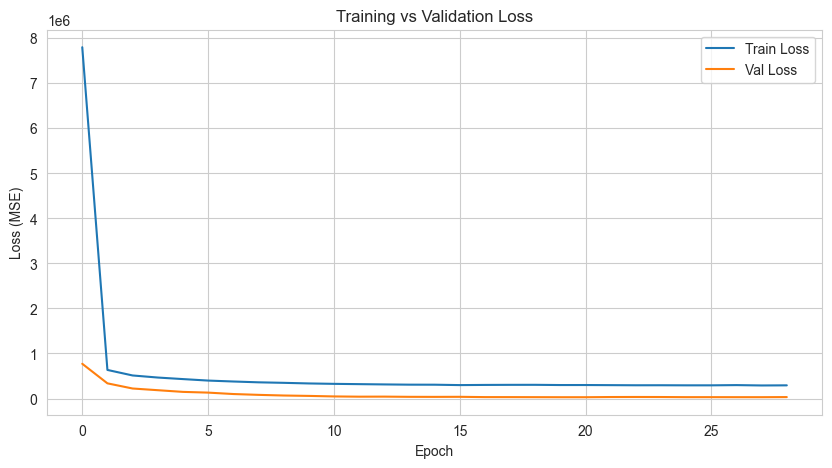

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
def mape(y_true, y_pred, eps=1e-6):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2)))

## 8) Evaluate (Val + Test)

In [29]:
# Validation
y_val_pred = model.predict(X_val_seq, verbose=0).reshape(-1)

val_mae  = mean_absolute_error(y_val_seq, y_val_pred)
val_rmse = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
val_mape = mape(y_val_seq, y_val_pred)

print("✅ Validation Metrics")
print("MAE :", val_mae)
print("RMSE:", val_rmse)
print("MAPE:", val_mape)

# Test
y_test_pred = model.predict(X_test_seq, verbose=0).reshape(-1)

test_mae  = mean_absolute_error(y_test_seq, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))
test_mape = mape(y_test_seq, y_test_pred)

print("\n✅ Test Metrics")
print("MAE :", test_mae)
print("RMSE:", test_rmse)
print("MAPE:", test_mape)

✅ Validation Metrics
MAE : 130.9374237060547
RMSE: 168.54969014173534
MAPE: 2.715101

✅ Test Metrics
MAE : 156.23736572265625
RMSE: 200.55041448473747
MAPE: 3.1987767


## 9) Save Outputs

In [30]:
from pathlib import Path
import joblib

OUT_DIR = Path("outputs_sequence_15min_template") / MODEL_NAME
OUT_DIR.mkdir(parents=True, exist_ok=True)

model.save(OUT_DIR / f"{MODEL_NAME}.keras")
joblib.dump(scaler, OUT_DIR / "scaler.joblib")

metrics = {
    "model": MODEL_NAME,
    "k_hours": int(K_HOURS),
    "k_steps": int(K_STEPS),
    "val_mae": float(val_mae),
    "val_rmse": float(val_rmse),
    "val_mape": float(val_mape),
    "test_mae": float(test_mae),
    "test_rmse": float(test_rmse),
    "test_mape": float(test_mape),
    "n_features": int(N_FEATURES),
    "split": {
        "train": [train_start, "2017-12-31"],
        "val": [val_start, "2018-12-31"],
        "test": [test_start, "2019-12-31"]
    }
}
(OUT_DIR / "metrics.json").write_text(json.dumps(metrics, indent=2))

pred_df = pd.DataFrame({
    "datetime": pd.to_datetime(t_test, utc=True),
    "Actual": y_test_seq,
    "Predicted": y_test_pred
})
pred_df.to_csv(OUT_DIR / "predictions.csv", index=False)

print("✅ Saved to:", OUT_DIR)

✅ Saved to: outputs_sequence_15min_template\cnn1d


## 10) Extra Visualizations (Template Style)

In [31]:
df_viz = pd.DataFrame({
    "datetime": pd.to_datetime(t_test, utc=True),
    "Actual": y_test_seq,
    "Predicted": y_test_pred
})

df_viz["Hour"] = df_viz["datetime"].dt.hour
df_viz["Month"] = df_viz["datetime"].dt.month
df_viz["DayOfWeek"] = df_viz["datetime"].dt.dayofweek
df_viz["IsWeekend"] = df_viz["DayOfWeek"].isin([5,6])

def get_season(m):
    if m in [12,1,2]: return "Winter"
    if m in [3,4,5]:  return "Spring"
    if m in [6,7,8]:  return "Summer"
    return "Autumn"

df_viz["Season"] = df_viz["Month"].apply(get_season)

display(df_viz.head())

,datetime,Actual,Predicted,Hour,Month,DayOfWeek,IsWeekend,Season
0,2019-01-02 00:00:00+00:00,3786.899902,3872.188232,0,1,2,False,Winter
1,2019-01-02 00:15:00+00:00,3741.030029,3822.672363,0,1,2,False,Winter
2,2019-01-02 00:30:00+00:00,3703.100098,3812.876709,0,1,2,False,Winter
3,2019-01-02 00:45:00+00:00,3656.770020,3820.694824,0,1,2,False,Winter
4,2019-01-02 01:00:00+00:00,3621.149902,3828.036621,1,1,2,False,Winter


✅ Saved: outputs_sequence_15min_template\cnn1d\time_series_comparison.png


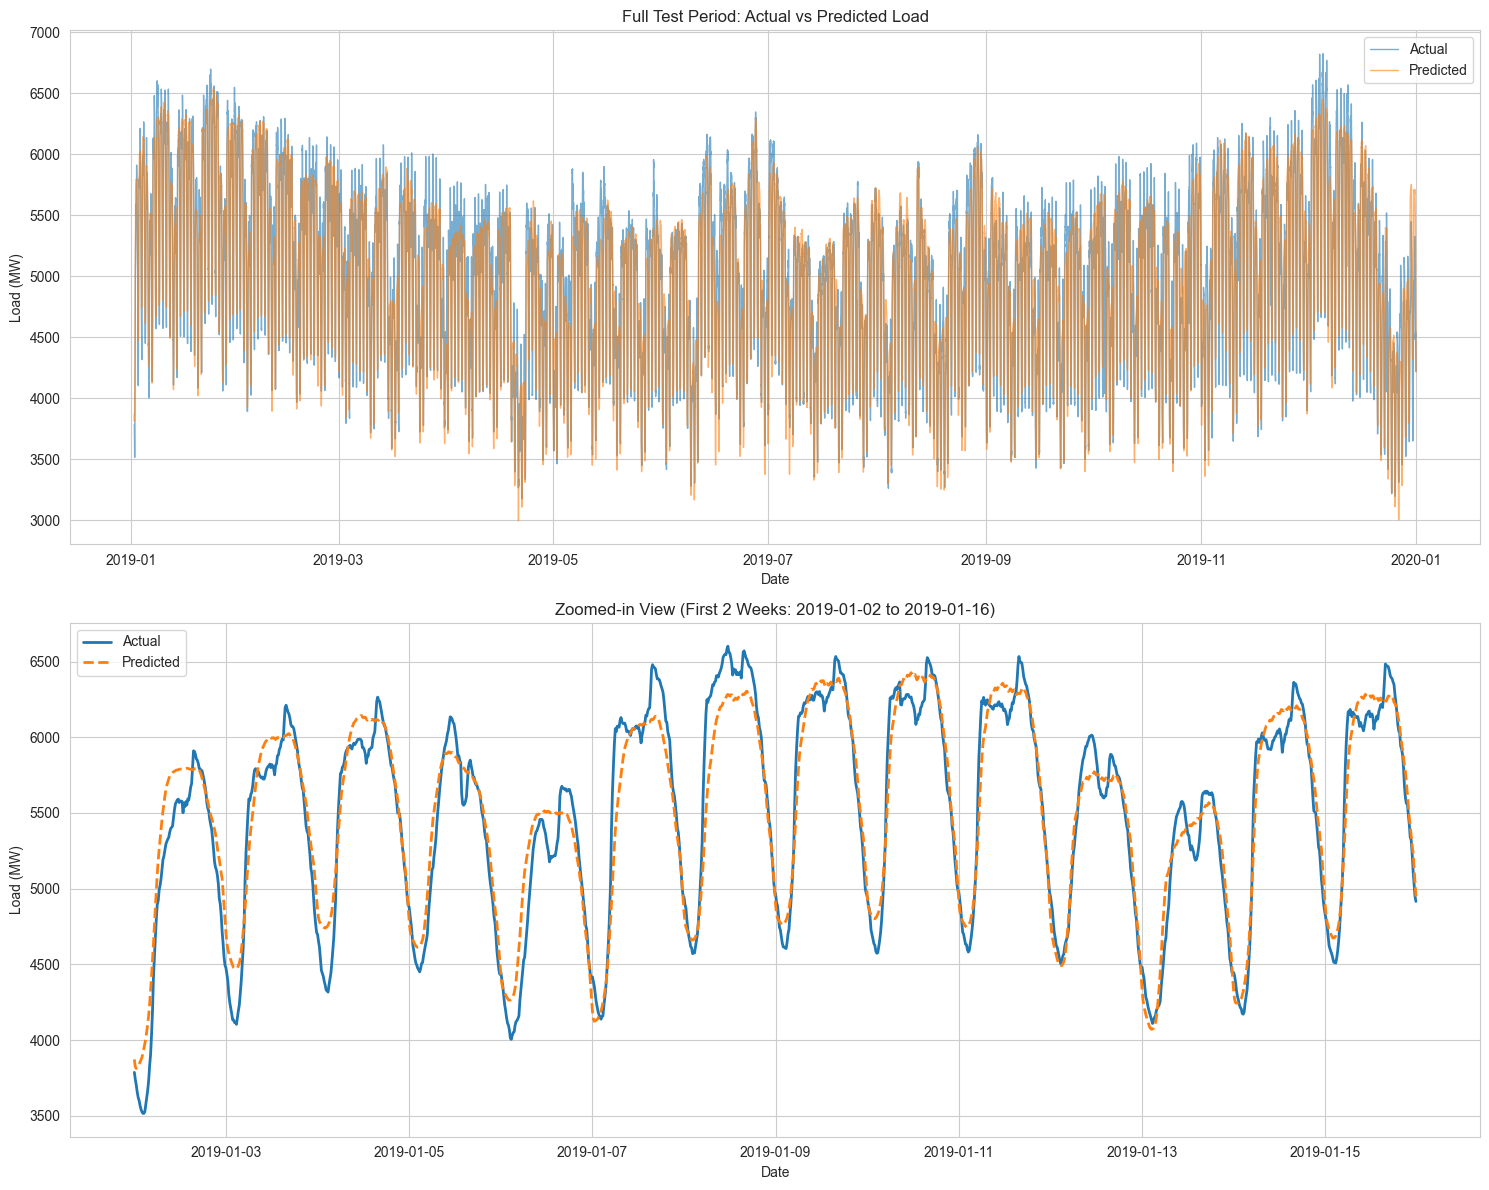

In [32]:
from pathlib import Path

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

axes[0].plot(df_viz["datetime"], df_viz["Actual"], label="Actual", alpha=0.6, linewidth=1)
axes[0].plot(df_viz["datetime"], df_viz["Predicted"], label="Predicted", alpha=0.6, linewidth=1)
axes[0].set_title("Full Test Period: Actual vs Predicted Load")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Load (MW)")
axes[0].legend()
axes[0].grid(True)

zoom_start = df_viz["datetime"].min()
zoom_end = zoom_start + pd.Timedelta(days=14)
df_zoom = df_viz[(df_viz["datetime"] >= zoom_start) & (df_viz["datetime"] < zoom_end)]

axes[1].plot(df_zoom["datetime"], df_zoom["Actual"], label="Actual", linewidth=2)
axes[1].plot(df_zoom["datetime"], df_zoom["Predicted"], label="Predicted", linewidth=2, linestyle="--")
axes[1].set_title(f"Zoomed-in View (First 2 Weeks: {zoom_start.date()} to {zoom_end.date()})")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Load (MW)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

plot_path = Path("outputs_sequence_15min_template") / MODEL_NAME / "time_series_comparison.png"
plot_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print("✅ Saved:", plot_path)
plt.show()

✅ Saved: outputs_sequence_15min_template\cnn1d\weekday_weekend_profiles.png


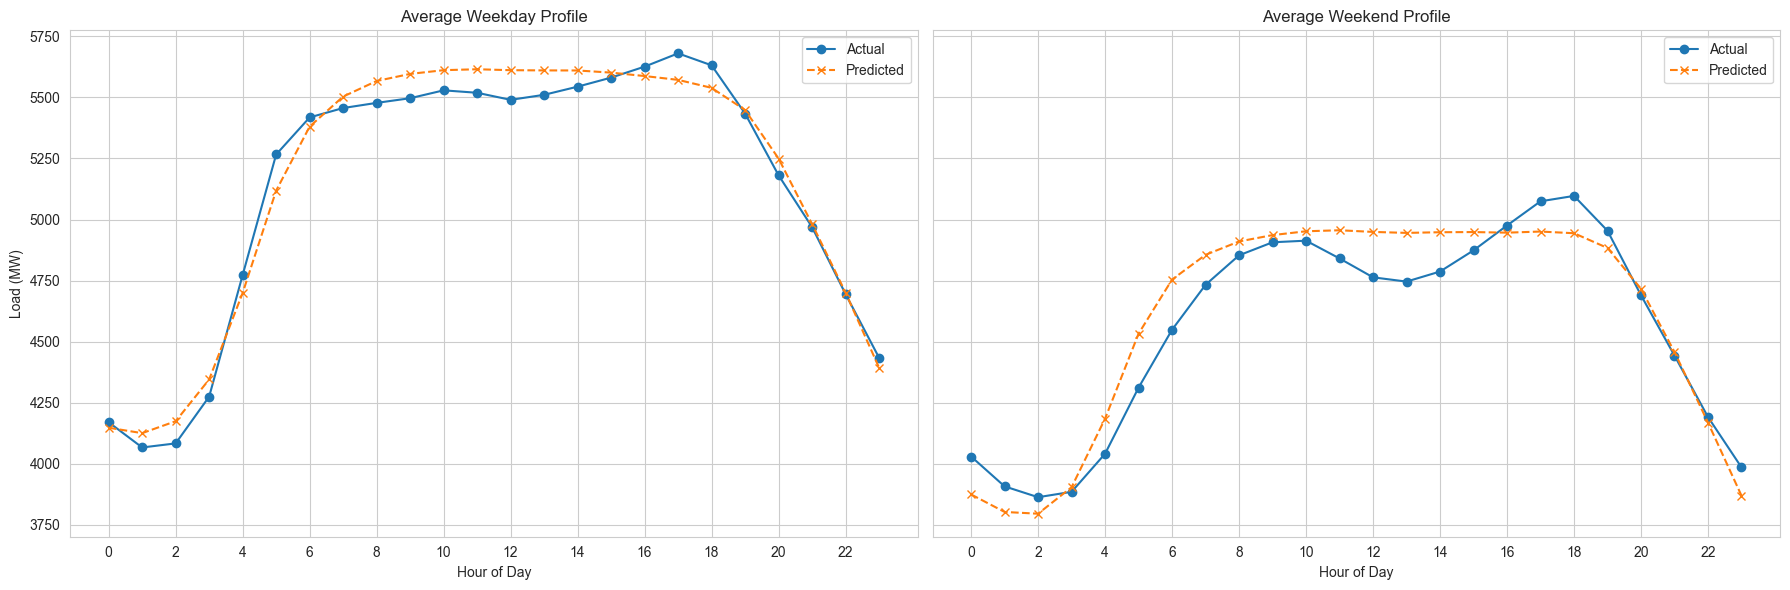

In [33]:
from pathlib import Path

weekday_df = df_viz[~df_viz["IsWeekend"]]
weekend_df = df_viz[df_viz["IsWeekend"]]

weekday_hourly = weekday_df.groupby("Hour")[["Actual", "Predicted"]].mean()
weekend_hourly = weekend_df.groupby("Hour")[["Actual", "Predicted"]].mean()

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

axes[0].plot(weekday_hourly.index, weekday_hourly["Actual"], label="Actual", marker="o")
axes[0].plot(weekday_hourly.index, weekday_hourly["Predicted"], label="Predicted", marker="x", linestyle="--")
axes[0].set_title("Average Weekday Profile")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Load (MW)")
axes[0].set_xticks(range(0,24,2))
axes[0].legend()
axes[0].grid(True)

axes[1].plot(weekend_hourly.index, weekend_hourly["Actual"], label="Actual", marker="o")
axes[1].plot(weekend_hourly.index, weekend_hourly["Predicted"], label="Predicted", marker="x", linestyle="--")
axes[1].set_title("Average Weekend Profile")
axes[1].set_xlabel("Hour of Day")
axes[1].set_xticks(range(0,24,2))
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plot_path = Path("outputs_sequence_15min_template") / MODEL_NAME / "weekday_weekend_profiles.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print("✅ Saved:", plot_path)
plt.show()

✅ Saved: outputs_sequence_15min_template\cnn1d\seasonal_profiles.png


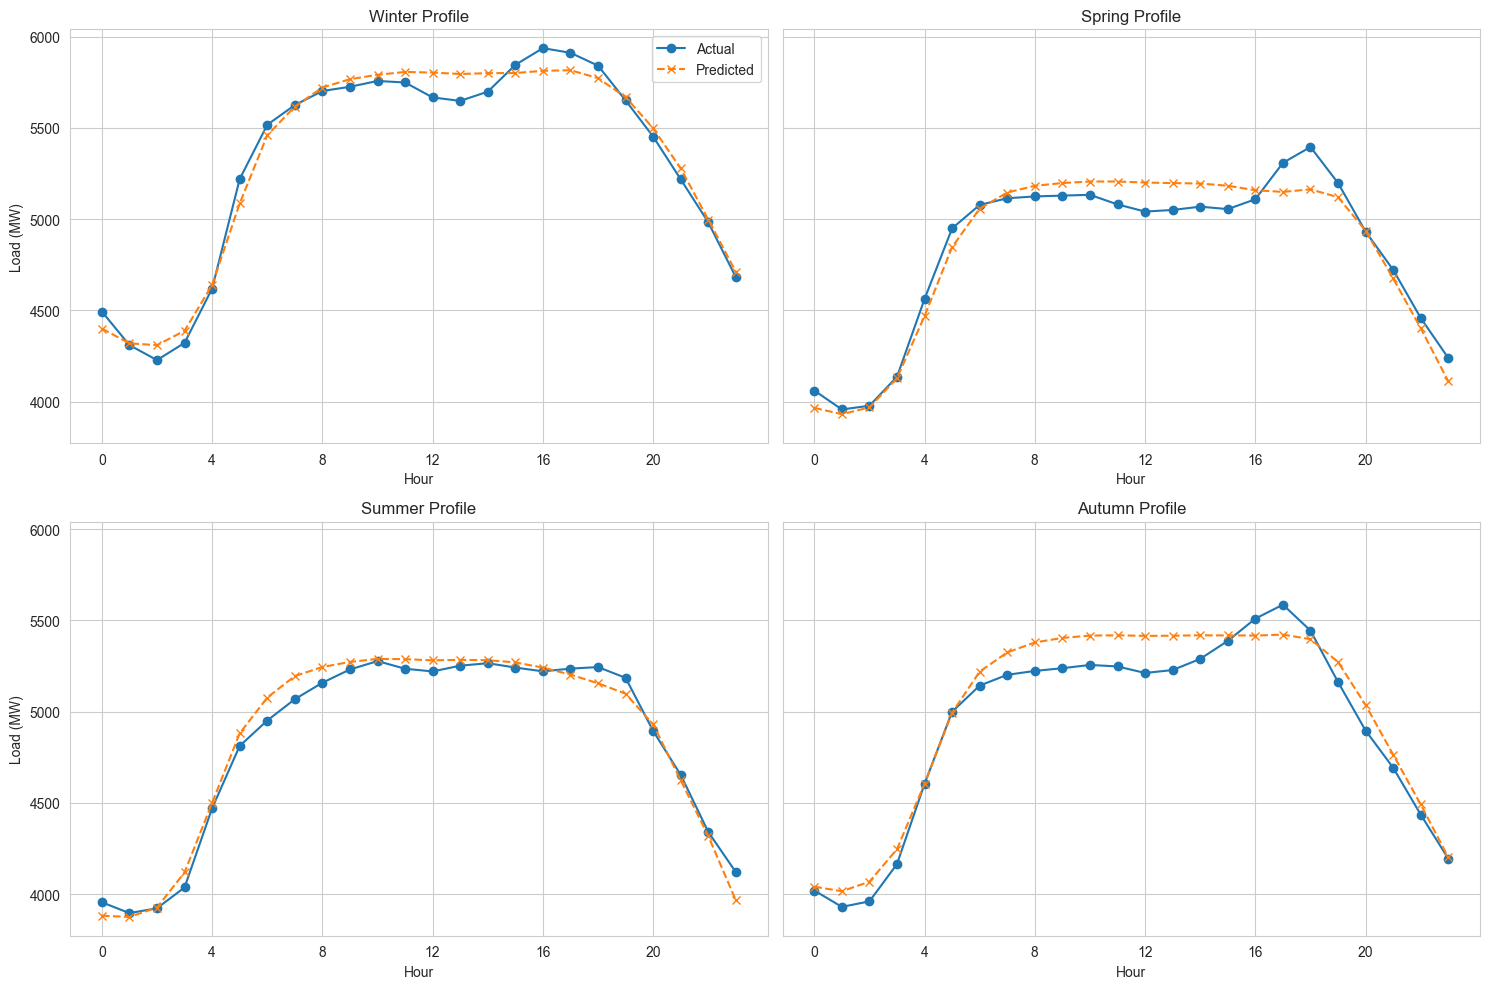

✅ Saved: outputs_sequence_15min_template\cnn1d\monthly_averages.png


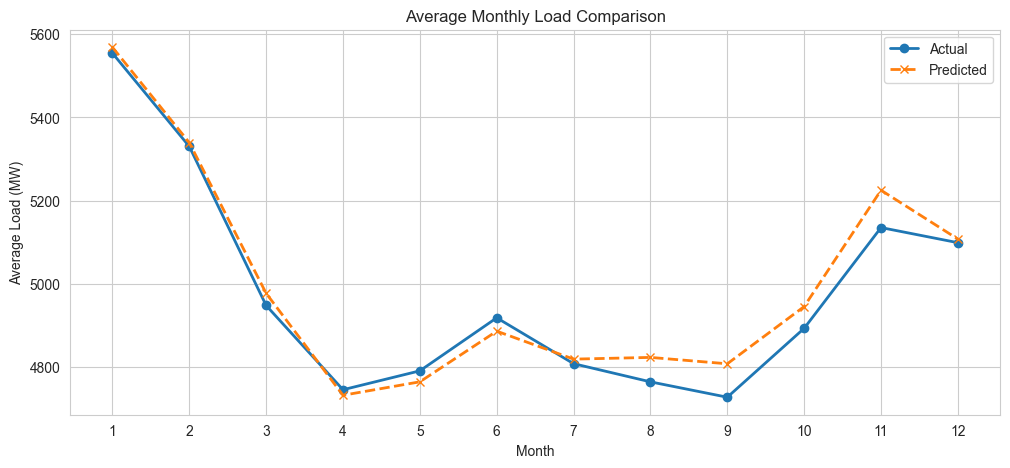

In [34]:
from pathlib import Path

# Seasonal profiles
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
axes = axes.flatten()
seasons = ["Winter", "Spring", "Summer", "Autumn"]

for i, season in enumerate(seasons):
    s = df_viz[df_viz["Season"] == season]
    hourly = s.groupby("Hour")[["Actual","Predicted"]].mean()
    axes[i].plot(hourly.index, hourly["Actual"], label="Actual", marker="o")
    axes[i].plot(hourly.index, hourly["Predicted"], label="Predicted", marker="x", linestyle="--")
    axes[i].set_title(f"{season} Profile")
    axes[i].set_xlabel("Hour")
    axes[i].set_xticks(range(0,24,4))
    axes[i].grid(True)
    if i == 0:
        axes[i].legend()

axes[0].set_ylabel("Load (MW)")
axes[2].set_ylabel("Load (MW)")

plt.tight_layout()
plot_path = Path("outputs_sequence_15min_template") / MODEL_NAME / "seasonal_profiles.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print("✅ Saved:", plot_path)
plt.show()

# Monthly averages
monthly = df_viz.groupby("Month")[["Actual","Predicted"]].mean()

plt.figure(figsize=(12, 5))
plt.plot(monthly.index, monthly["Actual"], label="Actual", marker="o", linewidth=2)
plt.plot(monthly.index, monthly["Predicted"], label="Predicted", marker="x", linestyle="--", linewidth=2)
plt.title("Average Monthly Load Comparison")
plt.xlabel("Month")
plt.ylabel("Average Load (MW)")
plt.xticks(range(1,13))
plt.legend()
plt.grid(True)

plot_path = Path("outputs_sequence_15min_template") / MODEL_NAME / "monthly_averages.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print("✅ Saved:", plot_path)
plt.show()

✅ Saved: outputs_sequence_15min_template\cnn1d\special_days_analysis.png


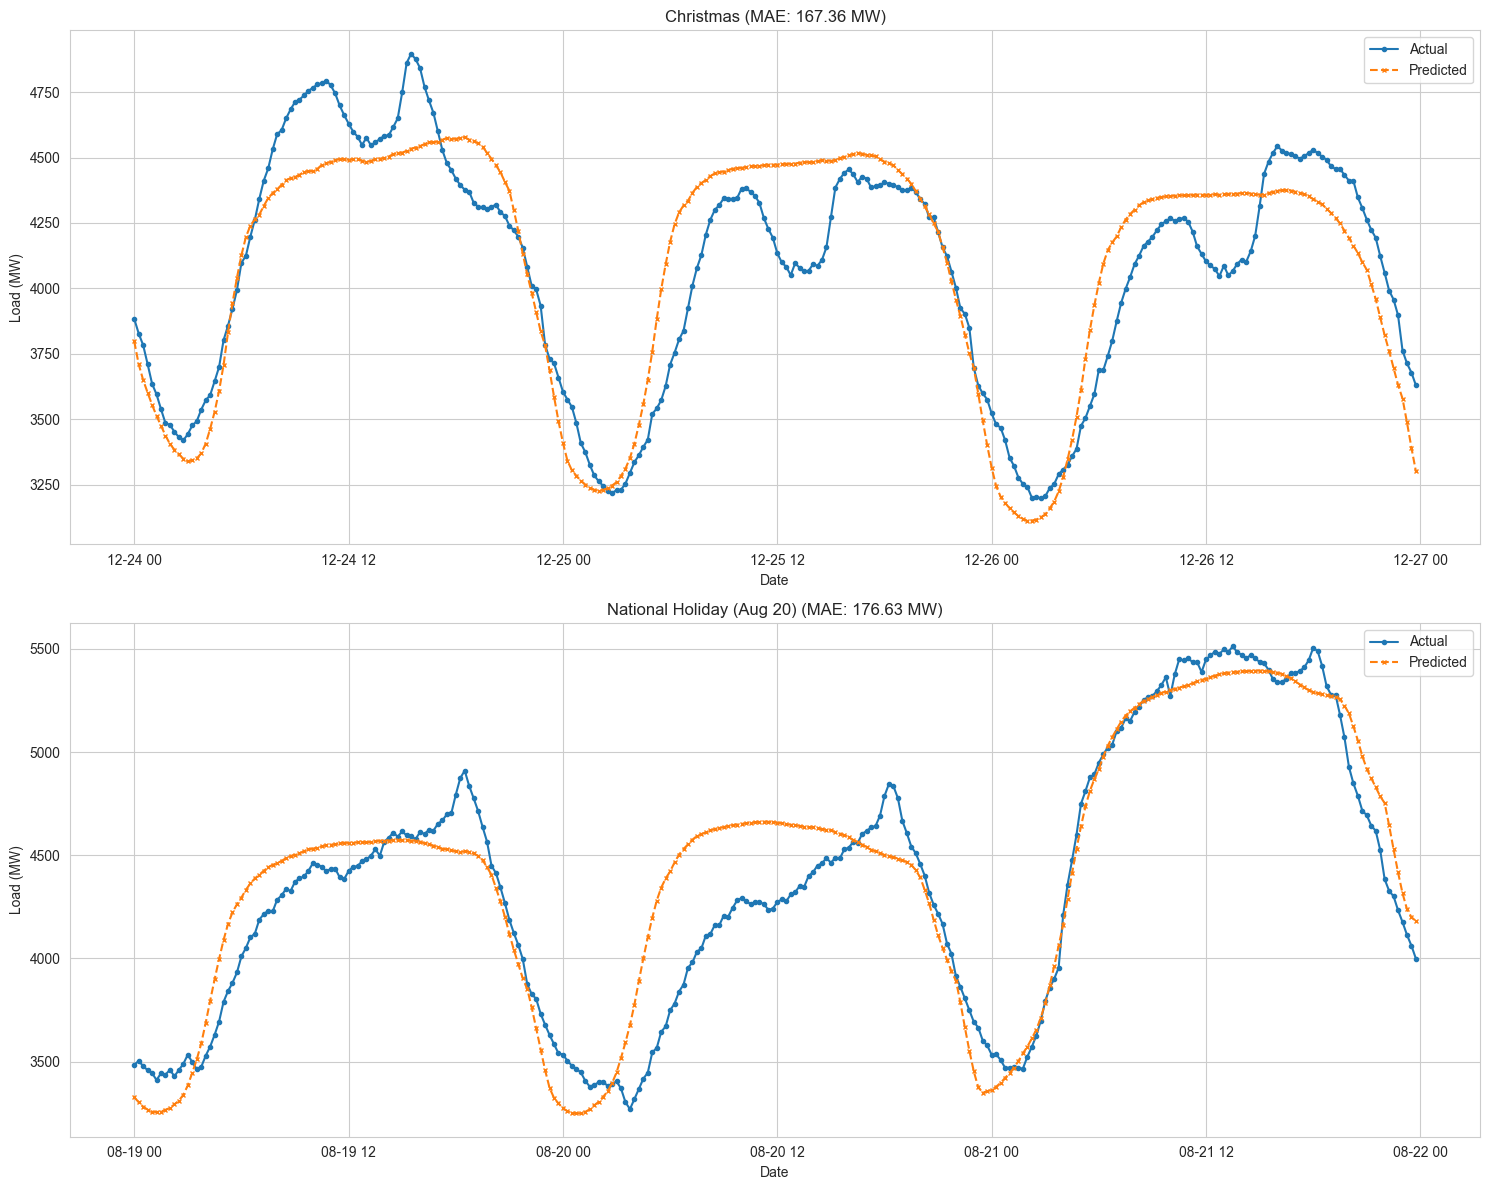

In [35]:
from pathlib import Path

# Special windows inside 2019 test year
special_periods = {
    "Christmas": ("2019-12-24", "2019-12-26"),
    "National Holiday (Aug 20)": ("2019-08-19", "2019-08-21"),
}

fig, axes = plt.subplots(len(special_periods), 1, figsize=(15, 6*len(special_periods)))
if len(special_periods) == 1:
    axes = [axes]

for ax, (name, (start_date, end_date)) in zip(axes, special_periods.items()):
    start_ts = pd.Timestamp(start_date).tz_localize("UTC")
    end_ts = pd.Timestamp(end_date).tz_localize("UTC") + pd.Timedelta(days=1)

    p = df_viz[(df_viz["datetime"] >= start_ts) & (df_viz["datetime"] < end_ts)].copy()
    if len(p) == 0:
        ax.set_title(f"{name} — not found in test window")
        ax.axis("off")
        continue

    period_mae = mean_absolute_error(p["Actual"], p["Predicted"])
    ax.plot(p["datetime"], p["Actual"], label="Actual", marker="o", markersize=3)
    ax.plot(p["datetime"], p["Predicted"], label="Predicted", marker="x", linestyle="--", markersize=3)
    ax.set_title(f"{name} (MAE: {period_mae:.2f} MW)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Load (MW)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plot_path = Path("outputs_sequence_15min_template") / MODEL_NAME / "special_days_analysis.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print("✅ Saved:", plot_path)
plt.show()

## 11) Summary Table

In [36]:
summary = pd.DataFrame([{
    "model": MODEL_NAME,
    "val_mae": float(val_mae),
    "val_rmse": float(val_rmse),
    "val_mape": float(val_mape),
    "test_mae": float(test_mae),
    "test_rmse": float(test_rmse),
    "test_mape": float(test_mape),
    "k_hours": int(K_HOURS),
    "k_steps": int(K_STEPS),
    "n_features": int(N_FEATURES)
}])
summary

,model,val_mae,val_rmse,val_mape,test_mae,test_rmse,test_mape,k_hours,k_steps,n_features
0,cnn1d,130.937424,168.54969,2.715101,156.237366,200.550414,3.198777,24,96,74
